# Convolutions
In this notebook we will introduce convolutions in devito and compare with their implementation in Scipy

In [1]:
!pip install Pillow

     |████████████████████████████████| 2.1 MB 613 kB/s eta 0:00:01     |████████████████████████████████| 2.1 MB 613 kB/s eta 0:00:01


In [17]:
#Python Imaging Library
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

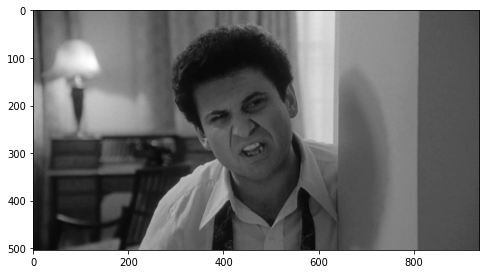

In [9]:
"""
Import the image, and convert it to 2D array
"""
image_path = "./joey.png"
img_raw = Image.open(image_path)
#convert to greyscale
img_greysc = img_raw.convert('LA')
#get the first band
img_2d = np.array(img_greysc.getdata(band=0),float)
img_2d.shape = (img_greysc.size[1], img_greysc.size[0])
#plot the image
fig = plt.figure(figsize=(8,12))
ax1 = fig.add_subplot(111)
ax1.imshow(img_2d, cmap='gray')

Now we will introduce convolutions in devito

In [11]:
from devito import Function, Operator, Eq, Grid, dimensions

SOBEL_VERTICAL = [[1, 0, -1],
                  [2, 0, -2],
                  [1, 0, -1]]


def get_function(name, matrix=None, shape=None, dimensions=None,
                 space_order=1):
    if matrix is None and shape is None:
        raise Exception("Either matrix or shape must be provided")

    if matrix is not None:
        shape = (len(matrix), len(matrix[0]))

    if dimensions is None:
        grid = Grid(shape=shape)
    else:
        grid = Grid(shape=shape, dimensions=dimensions)

    function = Function(name=name, grid=grid, space_order=space_order)

    if matrix is not None:
        function.data[:] = matrix

    return function


def error_check(kernel, image):
    if kernel is None or len(kernel) == 0:
        raise Exception("kernel must not be empty")

    if image is None or len(image) == 0:
        raise Exception("image must not be empty")

    different_row_length = False
    for row in kernel:
        if len(row) != len(kernel[0]):
            different_row_length = True
            break

    if different_row_length:
        raise Exception("kernel has an invalid shape")

    different_row_length = False
    for row in image:
        if len(row) != len(image[0]):
            different_row_length = True
            break

    if different_row_length:
        raise Exception("image has an invalid shape")

    if len(kernel) % 2 == 0 or len(kernel[0]) % 2 == 0:
        raise Exception("The dimensions of kernel must be odd")


def run(kernel, image):
    # It is assumed that both kernel and image have only two dimensions.

    error_check(kernel, image)

    A = get_function(name='A', matrix=kernel,
                     dimensions=dimensions('m n'), space_order=0)
    B = get_function(name='B', matrix=image, space_order=1)
    R = get_function(name='R', shape=B.shape, space_order=0)

    x, y = B.dimensions
    kernel_rows, kernel_cols = A.shape
    op = Operator(Eq(R,
                     sum([A[kernel_rows - i - 1,
                            kernel_cols - j - 1] *
                          B[x - kernel_rows // 2 + i,
                            y - kernel_cols // 2 + j]
                          for i in range(kernel_rows)
                          for j in range(kernel_cols)])))

    op.apply()
    return R.data




result = run(SOBEL_VERTICAL,
                 [[10, 16, 22, 4, 11],
                  [2, 2, 10, 10, 10],
                  [1, 2, 3, 4, 5],
                  [15, 15, 15, 15, 15],
                  [5, 5, 10, 10, 5]])
print(result)
#for this example the result should be 
# [[ 34.  32. -16. -22. -18.]
#  [ 22.  30.   6.  -9. -28.]
#  [ 21.  12.  12.   4. -33.]
#  [ 37.   7.   7.  -3. -44.]
#  [ 25.  10.  10. -10. -35.]]

Operator `Kernel` run in 0.01 s


[[ 34.  32. -16. -22. -18.]
 [ 22.  30.   6.  -9. -28.]
 [ 21.  12.  12.   4. -33.]
 [ 37.   7.   7.  -3. -44.]
 [ 25.  10.  10. -10. -35.]]


In [12]:
joey_convolve = run(SOBEL_VERTICAL, img_2d)

Operator `Kernel` run in 100.16 s


Now do the Vertical Sobel filter with scipy

In [20]:
# we need to specify the vertical filter
sk_convolve = ndimage.sobel(img_2d,1)

In [22]:
#measure the time it takes
%timeit sk_convolve = ndimage.sobel(img_2d,1)

6.76 ms ± 590 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We need to remove the padding, and confirm that the two methods yield the same result

In [24]:
print("Do we get the same result ? ", np.allclose(sk_convolve[1:-1,1:-1], joey_convolve[1:-1,1:-1]))

Do we get the same result ?  True


Now let's plot the results!

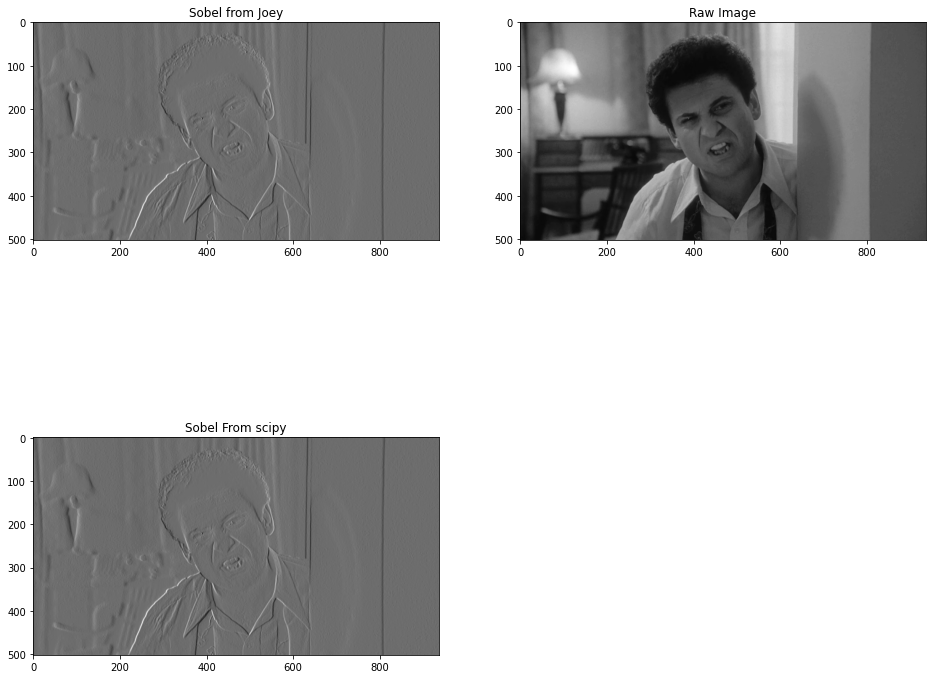

In [33]:
fig = plt.figure(figsize=(16,14))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax1.title.set_text('Sobel from Joey')
ax3.title.set_text('Sobel From scipy')
ax2.title.set_text('Raw Image')
ax1.imshow(joey_convolve[1:-1,1:-1], cmap='gray')
ax3.imshow(sk_convolve[1:-1,1:-1], cmap='gray')
ax2.imshow(img_2d[1:-1,1:-1], cmap='gray')
plt.show()